In [1]:
from os import environ as ENV
DATA = ENV['PWD'] + '/data/'

In [2]:
from time import time as now
from multiprocessing import Pool
from collections import Counter
import json

import pandas as pd
import qbraid

from tqdm.notebook import tqdm

In [3]:
import sys
sys.path.append('..')

from should_be_stdlib import *
from circuit_extra import *
from circuit_postprocess import *

In [4]:
# number of shots to use
SHOTS = 1000

# Load circuits

In [5]:
circuit_dfs = {
    k: pd.read_excel(DATA + f'circuits_{k}.xlsx', index_col=0)
    for k in [
        'ang', 'amp', 'amp-qft', 'amp-ddd', 'amp-qft-ddd'
    ]
}

{k: v['qasm2'].size for k,v in circuit_dfs.items()}

{'ang': 2926,
 'amp': 2926,
 'amp-qft': 2926,
 'amp-ddd': 2926,
 'amp-qft-ddd': 2926}

In [6]:
# transpile circuits ahead of time
# if IonQ-qiskit is installed, the ionq job submission expects qiskit circuits instead of the native ionq format!!
# but qiskit transpiler is much faster so it's fine
circuits = {
    k: [qbraid.transpile(c, 'qiskit') for c in tqdm(v['qasm2'])]
    for k,v in circuit_dfs.items()
}

  0%|          | 0/2926 [00:00<?, ?it/s]

/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/qbraid/_entrypoints.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  0%|          | 0/2926 [00:00<?, ?it/s]

  0%|          | 0/2926 [00:00<?, ?it/s]

  0%|          | 0/2926 [00:00<?, ?it/s]

  0%|          | 0/2926 [00:00<?, ?it/s]

In [7]:
for k,v in circuits.items():
    for i,c in enumerate(v):
        c.name = f'{k}_c{i}'

# IBMQ

## Connect to IBMQ API

In [8]:
from provider_ibmq import IBMQ
ibmq = IBMQ(
    ibm_api_key = open(ENV['HOME'] + '/work/api-keys/IBM_API_KEY').readline().strip(),
    ibm_crn = open(ENV['HOME'] + '/work/api-keys/IBM_CRN').readline().strip()
)
ibmq.printqpus()

# selected QPU
ibm_qpu = ibmq.provider.get_device('ibm_kingston')
ibm_qpu.status()

ibmq QiskitBackend('ibm_kingston') 156qb DeviceStatus.ONLINE
ibmq QiskitBackend('ibm_fez') 156qb DeviceStatus.ONLINE
ibmq QiskitBackend('ibm_marrakesh') 156qb DeviceStatus.ONLINE
ibmq QiskitBackend('ibm_torino') 133qb DeviceStatus.ONLINE
ibmq QiskitBackend('ibm_brisbane') 127qb DeviceStatus.ONLINE
ibmq QiskitBackend('ibm_sherbrooke') 127qb DeviceStatus.ONLINE


<DeviceStatus.ONLINE: 'online'>

## Run circuits

In [9]:
# 'ALL OK' or which jobs failed?
def faileds(jobs:dict[int,any]) -> dict[int,any] | str:
    ans = {
        k:v.status() for k,v in jobs.items()
        if not v.status().value == 'COMPLETED'
    }
    return 'ALL OK' if len(ans) == 0 else ans

### Basic test run

### Real jobs (all of them)

In [10]:
try: jobs
except: jobs = {}

In [11]:
# Ang
try:
    print(faileds(jobs['ang']))
except:
    if verify_run():
        jobs['ang'] = {
            i: ibm_qpu.run(circuits_chunk, shots=SHOTS)
            for i, circuits_chunk in tqdm(chunk(circuits['ang'], 50).items())
        }

You must type "REALLY" to run this because it may cost a lot of money!!! >>>  


By not typing "REALLY", you did not run this code


In [12]:
# Amp+QFT & Amp+QFT+DDD
try:
    print(faileds(jobs['amp-qft']))
    print(faileds(jobs['amp-qft-ddd']))
except:
    if verify_run():
        jobs['amp-qft-ddd'] = {
            i: ibm_qpu.run(circuits_chunk, shots=SHOTS)
            for i, circuits_chunk in tqdm(chunk(circuits['amp-qft-ddd'], 45).items())
        }
        jobs['amp-qft'] = {
            i: ibm_qpu.run(circuits_chunk, shots=SHOTS)
            for i, circuits_chunk in tqdm(chunk(circuits['amp-qft'], 40).items())
        }

You must type "REALLY" to run this because it may cost a lot of money!!! >>>  


By not typing "REALLY", you did not run this code


In [13]:
# Amp & Amp+DDD
try:
    print(faileds(jobs['amp']))
    print(faileds(jobs['amp-ddd']))
except:
    if verify_run():
        jobs['amp'] = {
            i: ibm_qpu.run(circuits_chunk, shots=SHOTS)
            for i, circuits_chunk in tqdm(chunk(circuits['amp'], 47).items())
        }
        jobs['amp_ddd'] = {
            i: ibm_qpu.run(circuits_chunk, shots=SHOTS)
            for i, circuits_chunk in tqdm(chunk(circuits['amp-ddd'], 42).items())
        }

You must type "REALLY" to run this because it may cost a lot of money!!! >>>  


By not typing "REALLY", you did not run this code


### Save/Load Job IDs
`job_ids[circuit_type][circuit_index] = job_id`

In [14]:
# save job id list
if len(jobs) > 0:
    with open(ENV['HOME'] + '/work/jobs.json', 'wt') as f:
        json.dump({
            # convert jobs to job_ids for api work
            k: [ibmq.jobid(j) for j in vs]
            for k, vs in jobs.items()
        }, fp=f, indent=4)

# load job id list
with open(ENV['HOME'] + '/work/jobs.json', 'rt') as f:
    job_ids = json.load(fp=f)

## Results

### Loading
From IBMQ API

In [15]:
results = {
    k: sum([list(ibmq.jobresult(v).values()) for v in tqdm(vs, desc=k)], [])
    for k, vs in tqdm(job_ids.items(), desc='retrieve results')
}

retrieve results:   0%|          | 0/5 [00:00<?, ?it/s]

ang:   0%|          | 0/59 [00:00<?, ?it/s]

amp-qft-ddd:   0%|          | 0/66 [00:00<?, ?it/s]

amp-qft:   0%|          | 0/74 [00:00<?, ?it/s]

amp:   0%|          | 0/63 [00:00<?, ?it/s]

amp-ddd:   0%|          | 0/70 [00:00<?, ?it/s]

### Calculate!
For the Ang circuits, evaluate the swap expectation.   
For the Amp-based circuits, calculate the % of 0.

In [16]:
metrics = {
    'ang': np.array([swap_expectation({int(k,2):v for k,v in r.items()})[1] for r in results['ang']]),
    'amp-qft': np.array([{int(k,2):v for k,v in r.items()}.get(0,0) for r in results['amp-qft']]) / SHOTS,
    'amp-qft-ddd': np.array([{int(k,2):v for k,v in r.items()}.get(0,0) for r in results['amp-qft-ddd']]) / SHOTS,
    'amp': np.array([{int(k,2):v for k,v in r.items()}.get(0,0) for r in results['amp']]) / SHOTS,
    'amp-ddd': np.array([{int(k,2):v for k,v in r.items()}.get(0,0) for r in results['amp-ddd']]) / SHOTS,
}
metrics

{'ang': array([0.50137329, 0.50158691, 0.50156403, ..., 0.50159836, 0.50159073,
        0.50161362], shape=(2926,)),
 'amp-qft': array([0.36 , 0.685, 0.578, ..., 0.74 , 0.712, 0.73 ], shape=(2926,)),
 'amp-qft-ddd': array([0.356, 0.661, 0.55 , ..., 0.71 , 0.697, 0.708], shape=(2926,)),
 'amp': array([0.565, 0.776, 0.709, ..., 0.767, 0.757, 0.79 ], shape=(2926,)),
 'amp-ddd': array([0.62 , 0.774, 0.685, ..., 0.833, 0.828, 0.846], shape=(2926,))}

In [17]:
metrics_df = pd.DataFrame({
    'A': circuit_dfs['ang']['A'],
    'B': circuit_dfs['ang']['B'],
    **metrics
})
metrics_df

,A,B,ang,amp-qft,amp-qft-ddd,amp,amp-ddd
0,23,32,0.501373,0.360,0.356,0.565,0.620
1,23,35,0.501587,0.685,0.661,0.776,0.774
2,23,36,0.501564,0.578,0.550,0.709,0.685
3,23,37,0.501579,0.648,0.602,0.763,0.758
4,23,50,0.501617,0.656,0.696,0.756,0.771
...,...,...,...,...,...,...,...
2921,424,424,0.501621,0.712,0.696,0.787,0.838
2922,425,425,0.501610,0.741,0.710,0.732,0.838
2923,426,426,0.501598,0.740,0.710,0.767,0.833
2924,428,428,0.501591,0.712,0.697,0.757,0.828


In [18]:
metrics_df.to_excel(DATA + 'results_ibm-kingston.xlsx')

## Circuits Analysis
Pull them back from the API

In [19]:
circuits_real = {
    k: sum(sum([ibmq.jobcircuit(j) for j in tqdm(js, desc=k)], []), [])
    for k, js in tqdm(job_ids.items(), desc='retrieve circuits')
}

retrieve circuits:   0%|          | 0/5 [00:00<?, ?it/s]

ang:   0%|          | 0/59 [00:00<?, ?it/s]

amp-qft-ddd:   0%|          | 0/66 [00:00<?, ?it/s]

amp-qft:   0%|          | 0/74 [00:00<?, ?it/s]

amp:   0%|          | 0/63 [00:00<?, ?it/s]

amp-ddd:   0%|          | 0/70 [00:00<?, ?it/s]

### Circuit Statistics

In [20]:
def stats(circuit_map):
    return {
        k: pd.concat([
            circuit_dfs[k][['A', 'B']],
            pd.DataFrame([
                (
                    len(v),
                    v.depth(),
                    v.num_nonlocal_gates(),
                    Counter(g.name for g in v),
                )
                for v in vs
            ], columns=['gates', 'depth', '2-gates', 'Gates'])
        ], axis=1)
        for k, vs in circuit_map.items()
    }

In [21]:
# circuits_stats = stats(circuits)
circuits_real_stats = stats(circuits_real)

In [22]:
for k, v in circuits_real_stats.items():
    v.to_csv(DATA + f'results_ibm-kingston_stats_{k}.csv')

### Draw some

8 9


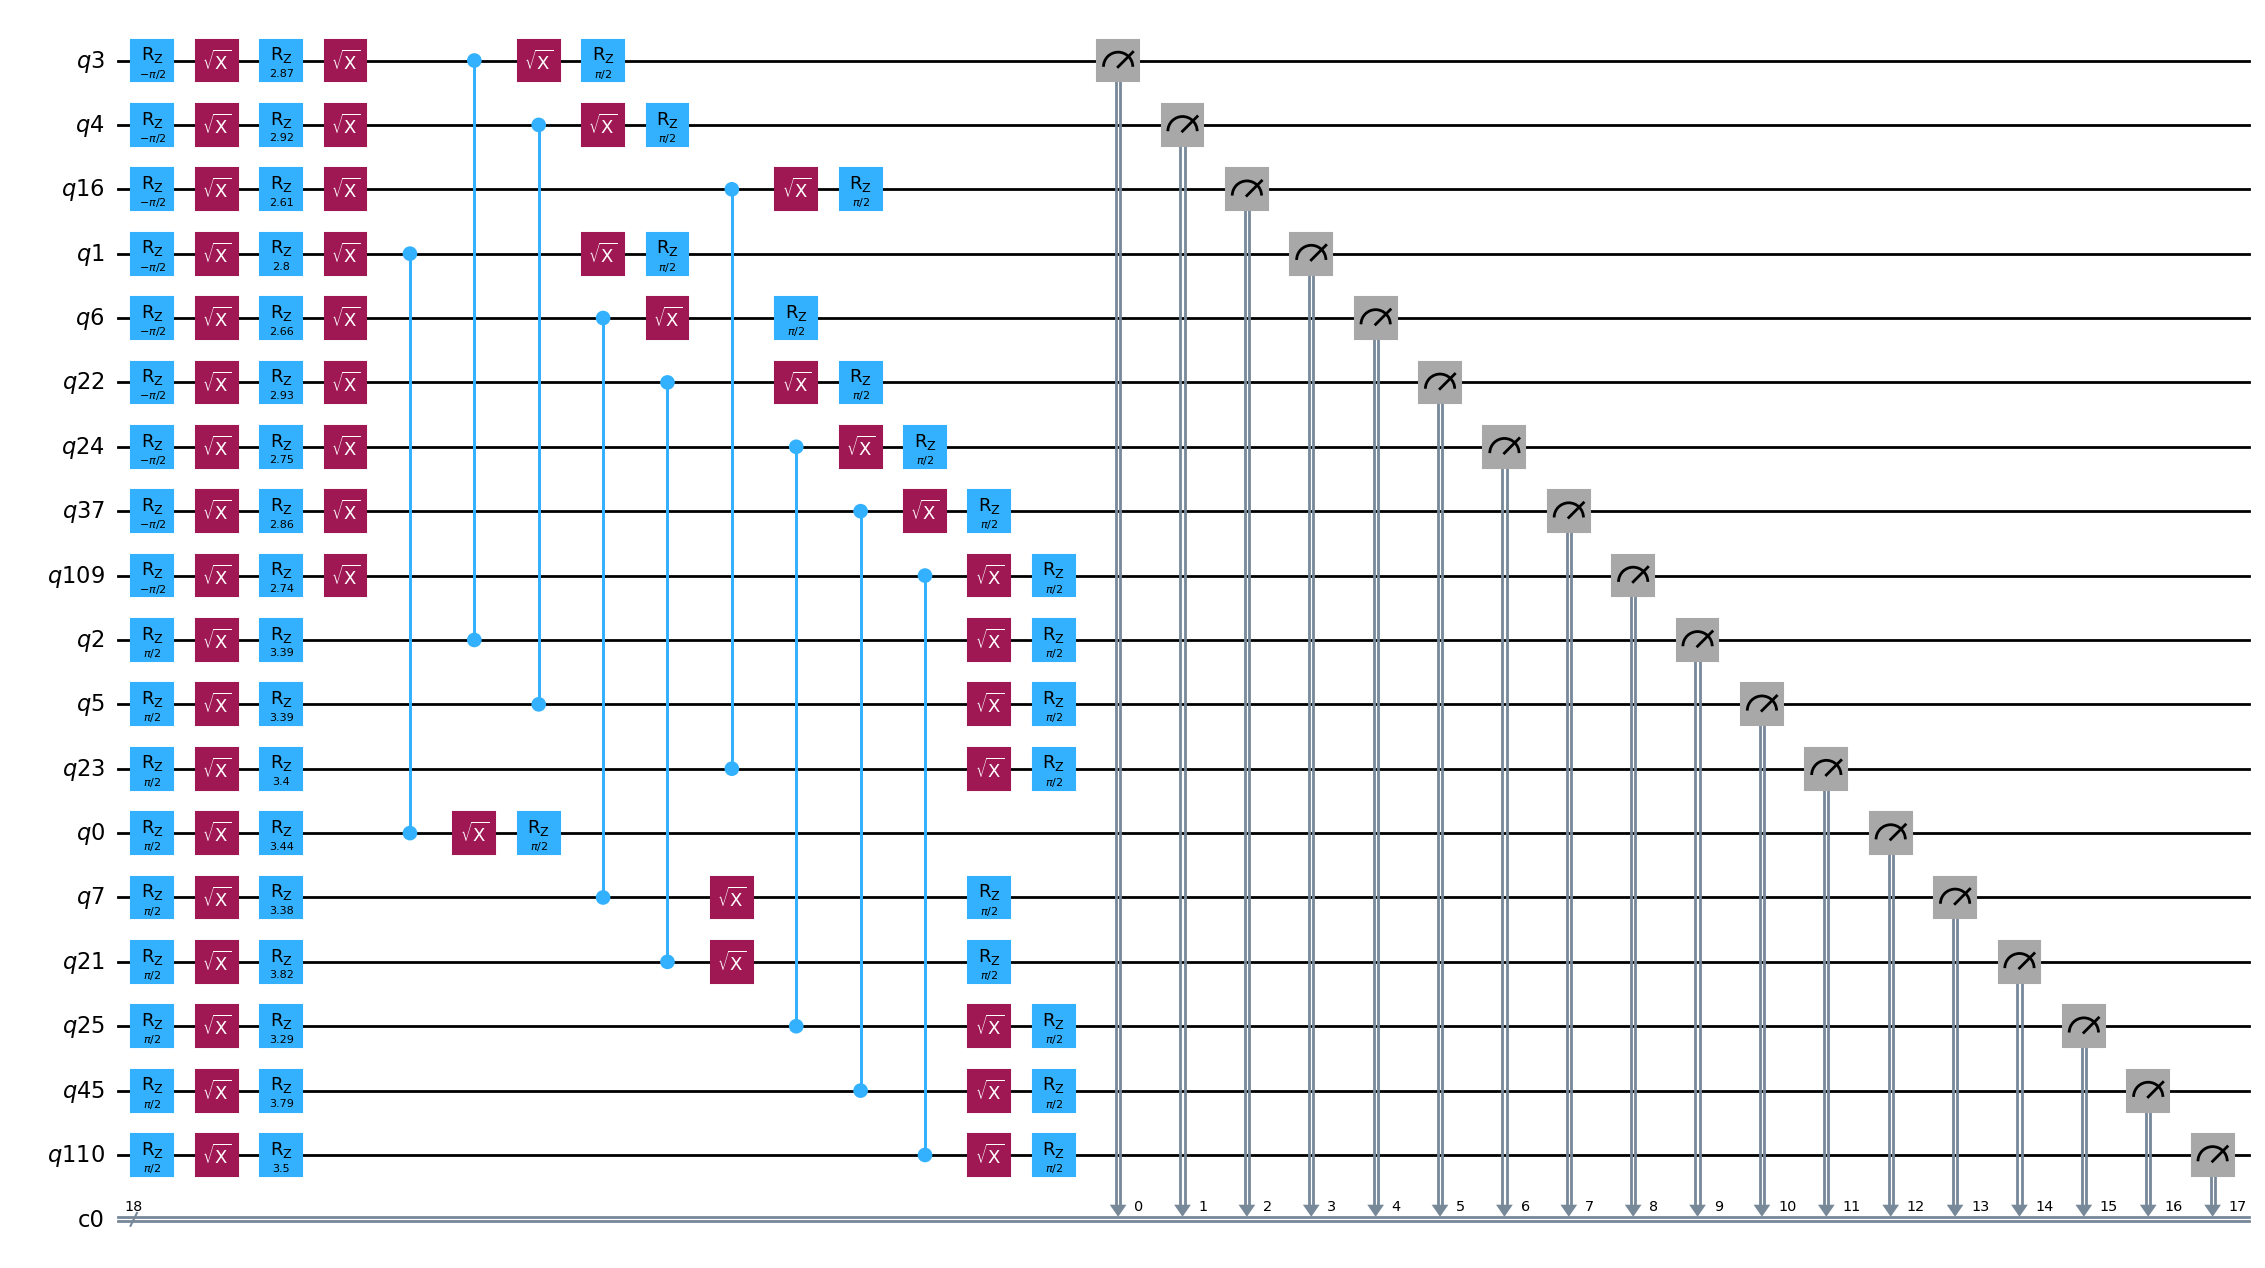

In [23]:
n = 'ang'
print(
    circuits_real[n][0].depth(),
    circuits_real[n][0].num_nonlocal_gates(),
)
circuits_real[n][0].trim().draw('mpl', fold=60)

285 68


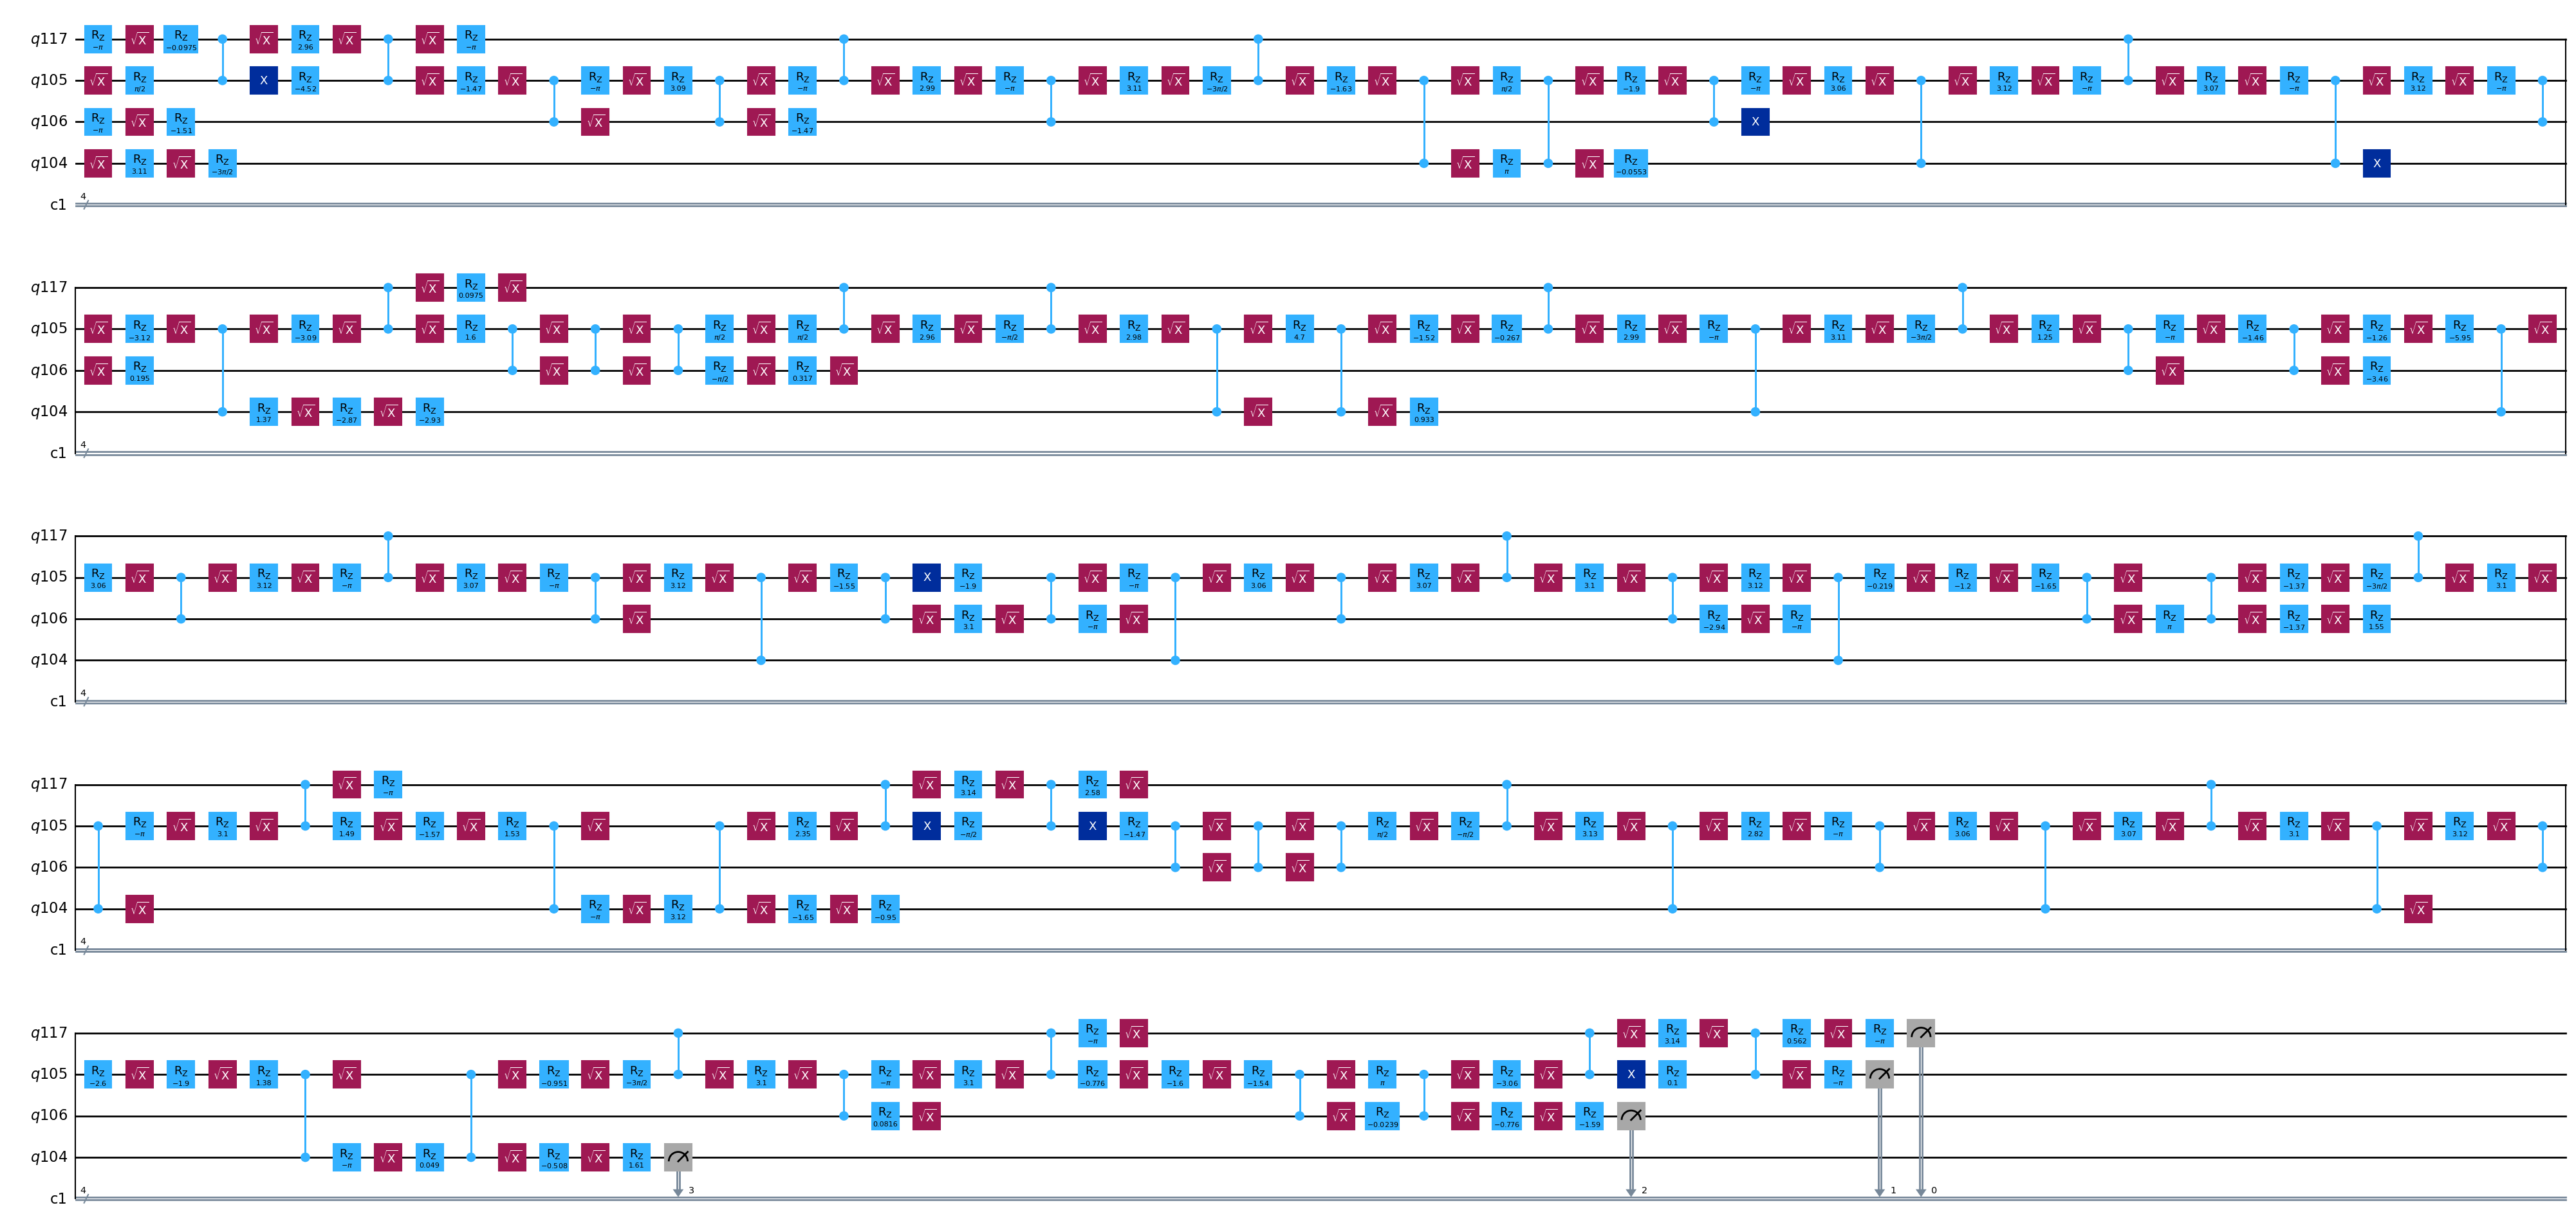

In [24]:
n = 'amp'
print(
    circuits_real[n][0].depth(),
    circuits_real[n][0].num_nonlocal_gates(),
)
circuits_real[n][0].trim().draw('mpl', fold=60)

407 110


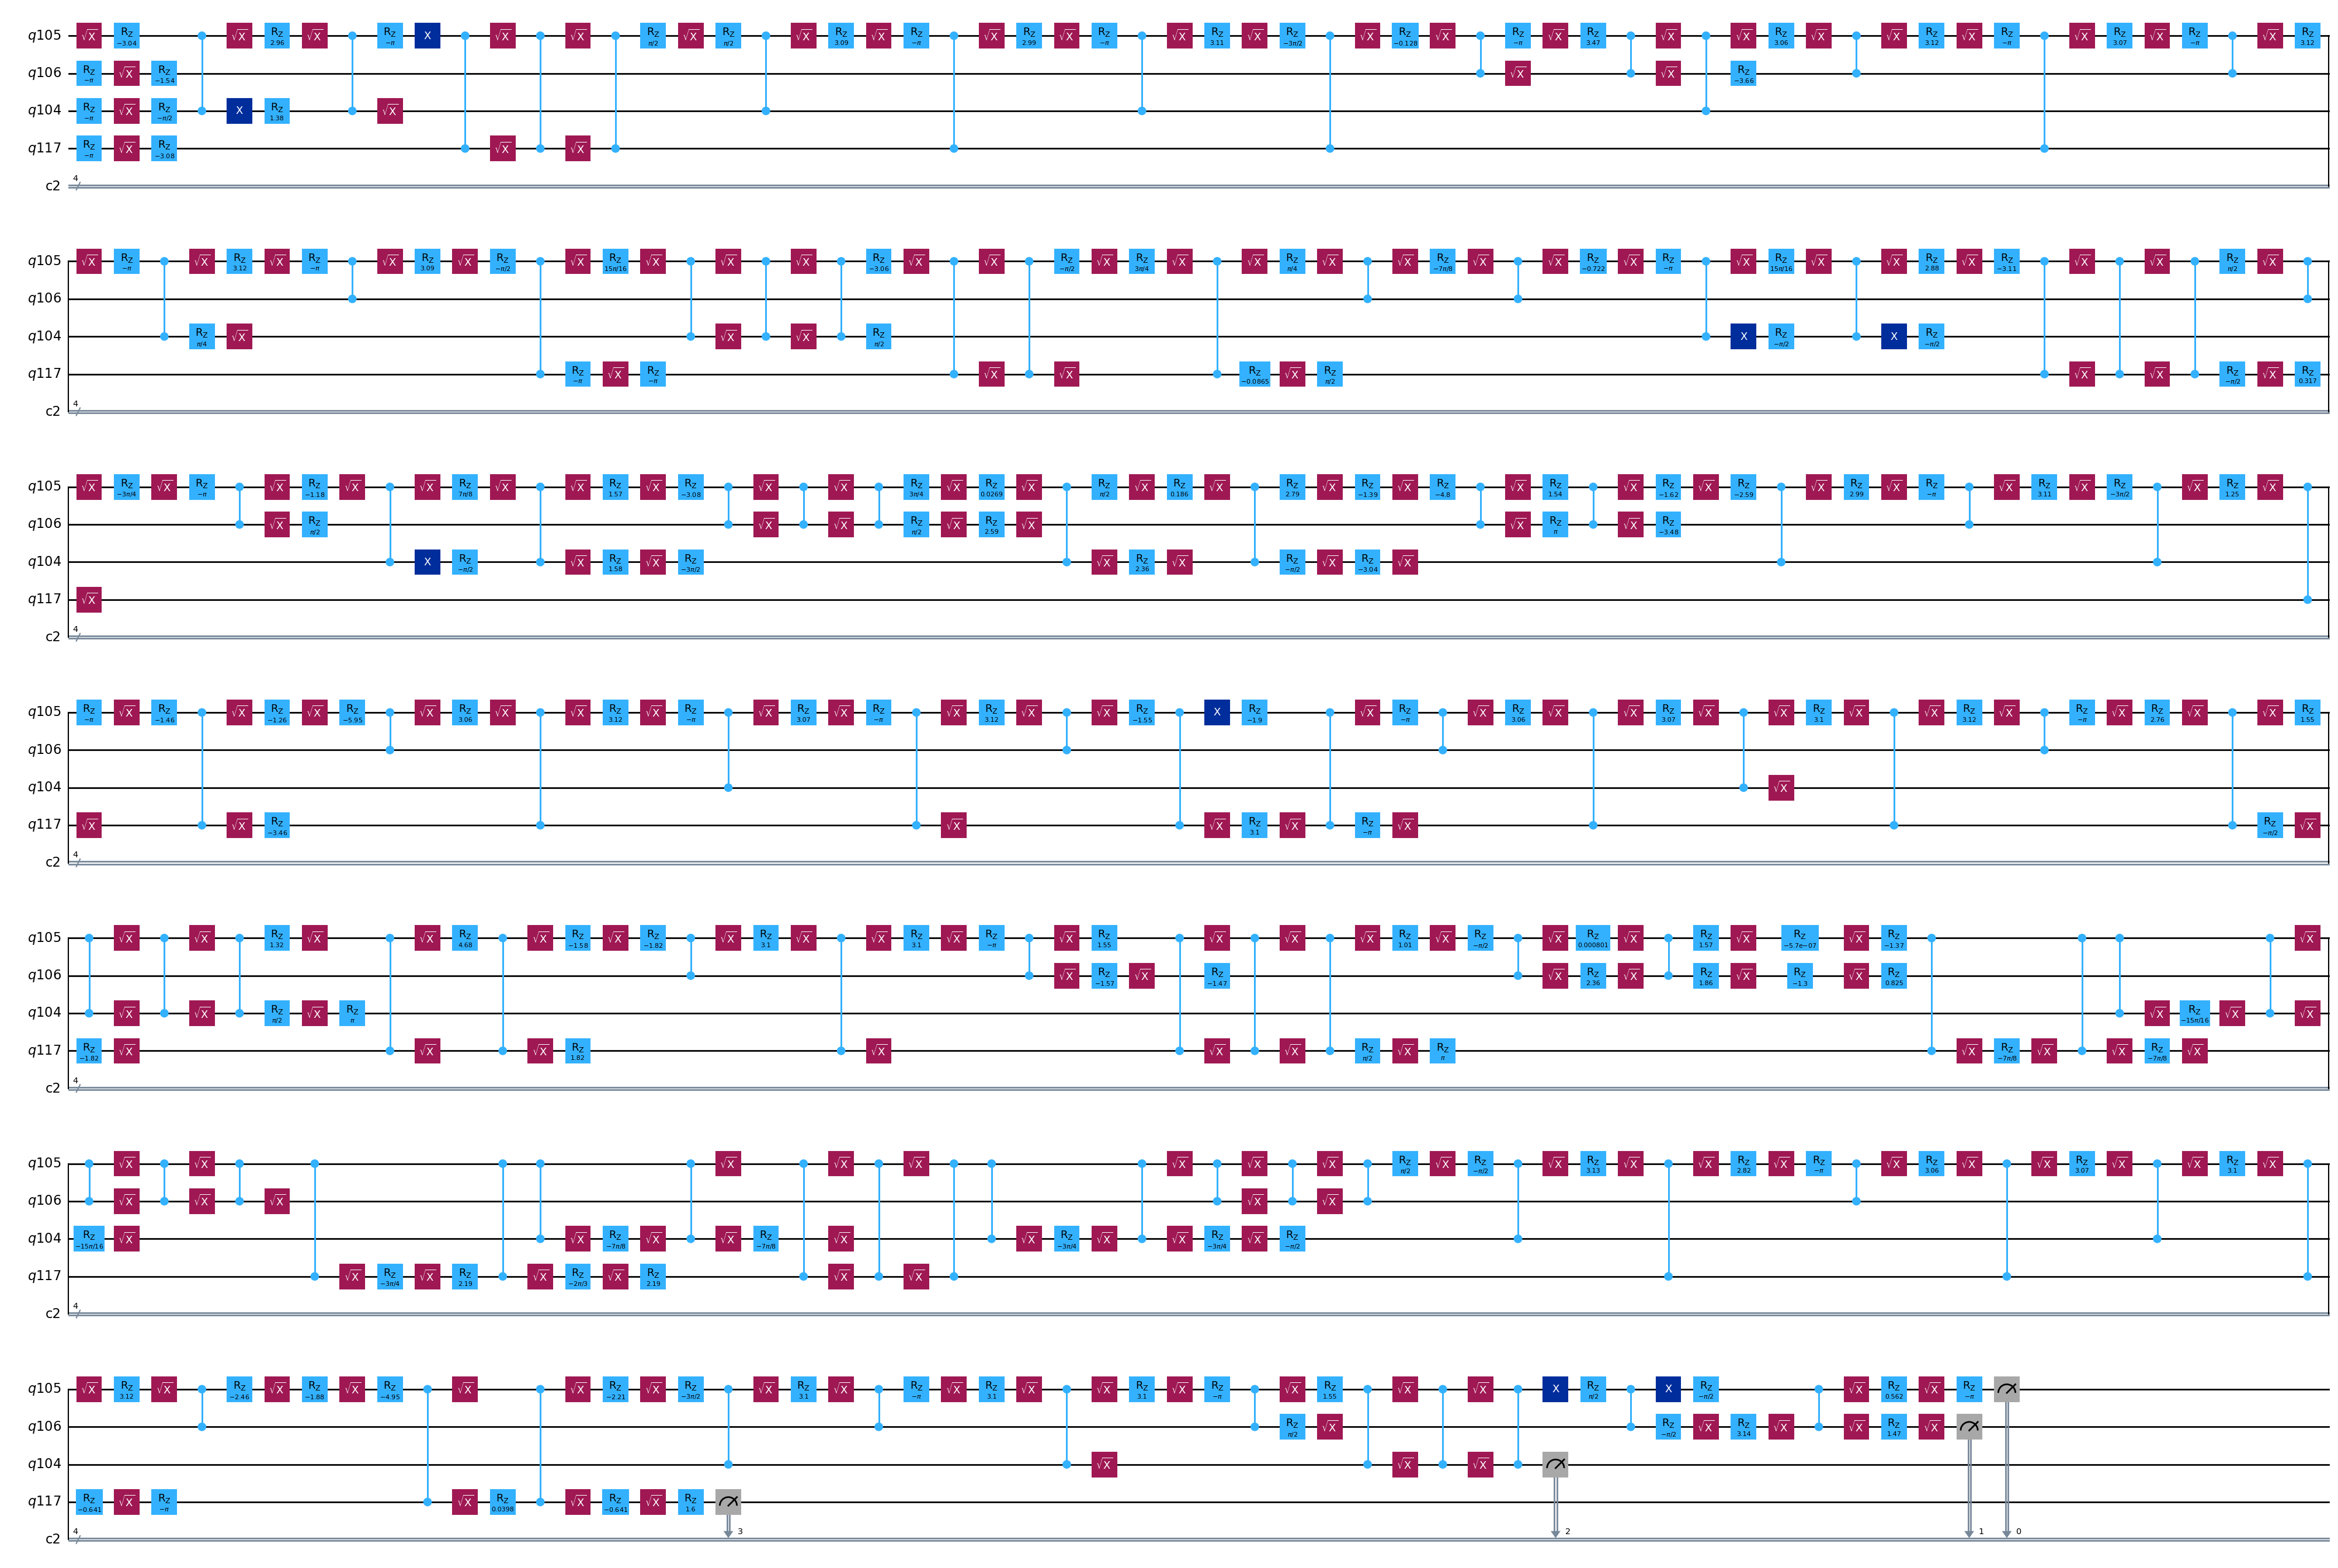

In [25]:
n = 'amp-qft'
print(
    circuits_real[n][0].depth(),
    circuits_real[n][0].num_nonlocal_gates(),
)
circuits_real[n][0].trim().draw('mpl', fold=60)

401 108


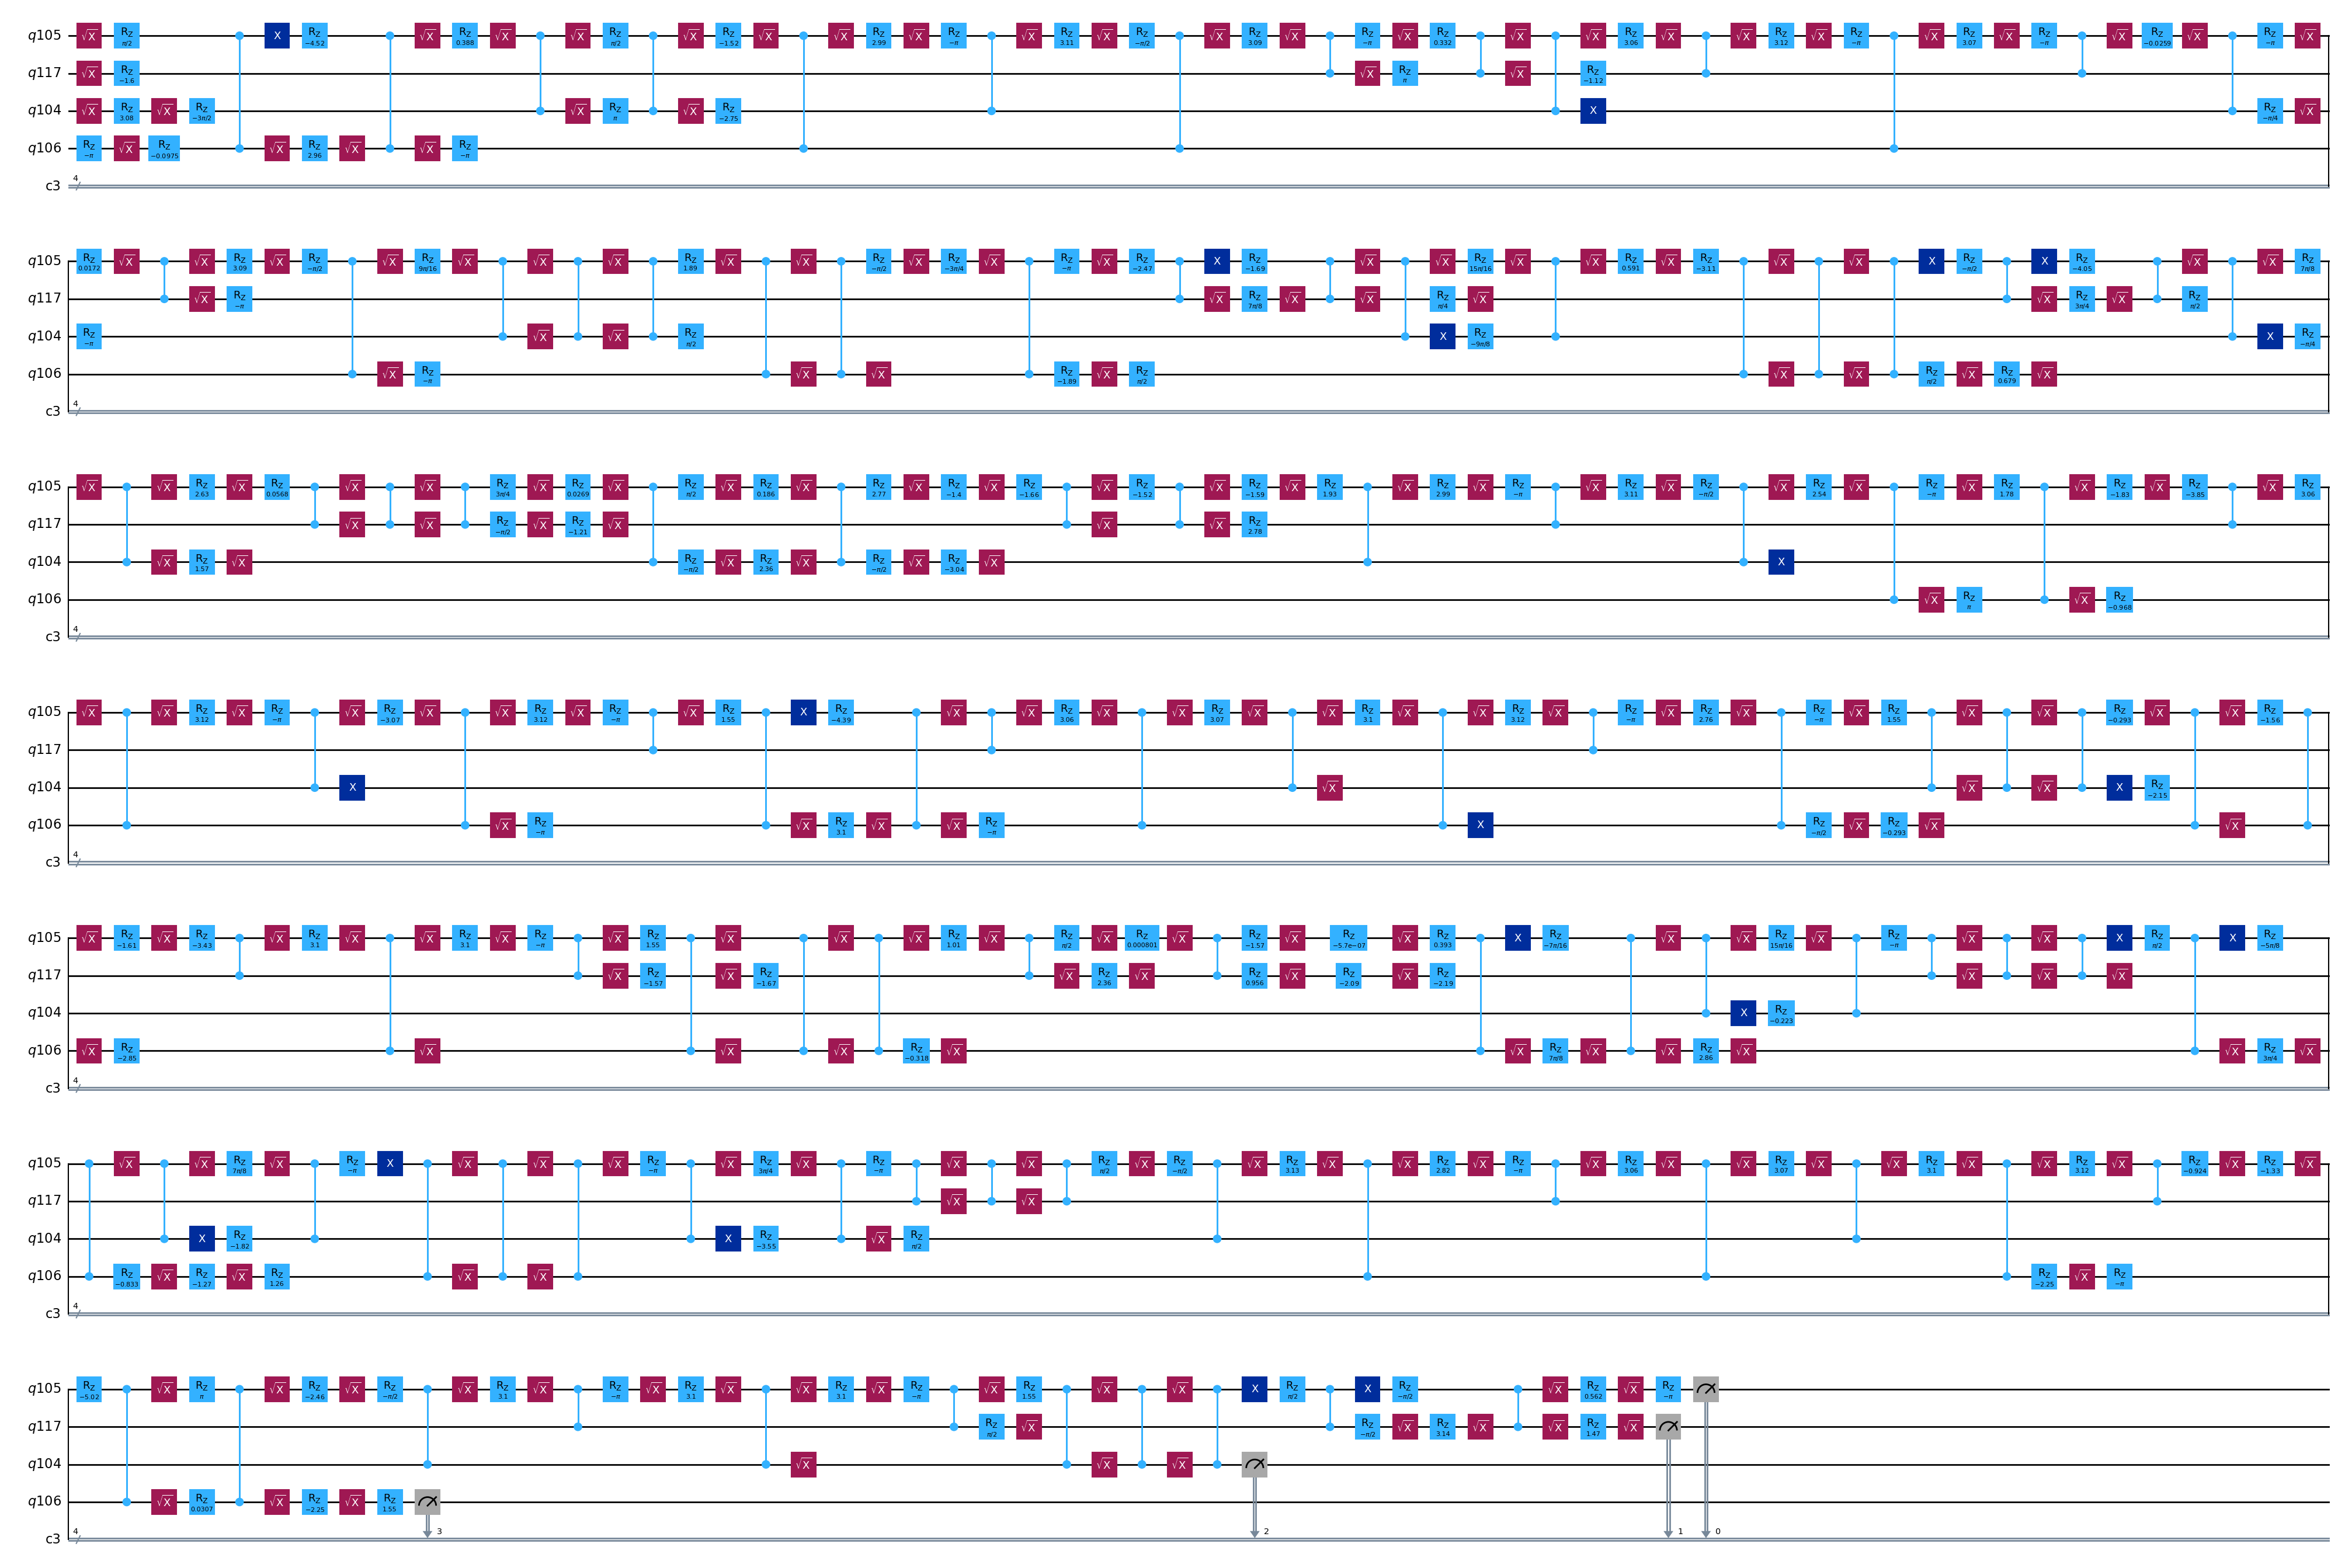

In [26]:
n = 'amp-qft-ddd'
print(
    circuits_real[n][0].depth(),
    circuits_real[n][0].num_nonlocal_gates(),
)
circuits_real[n][0].trim().draw('mpl', fold=60)

280 68


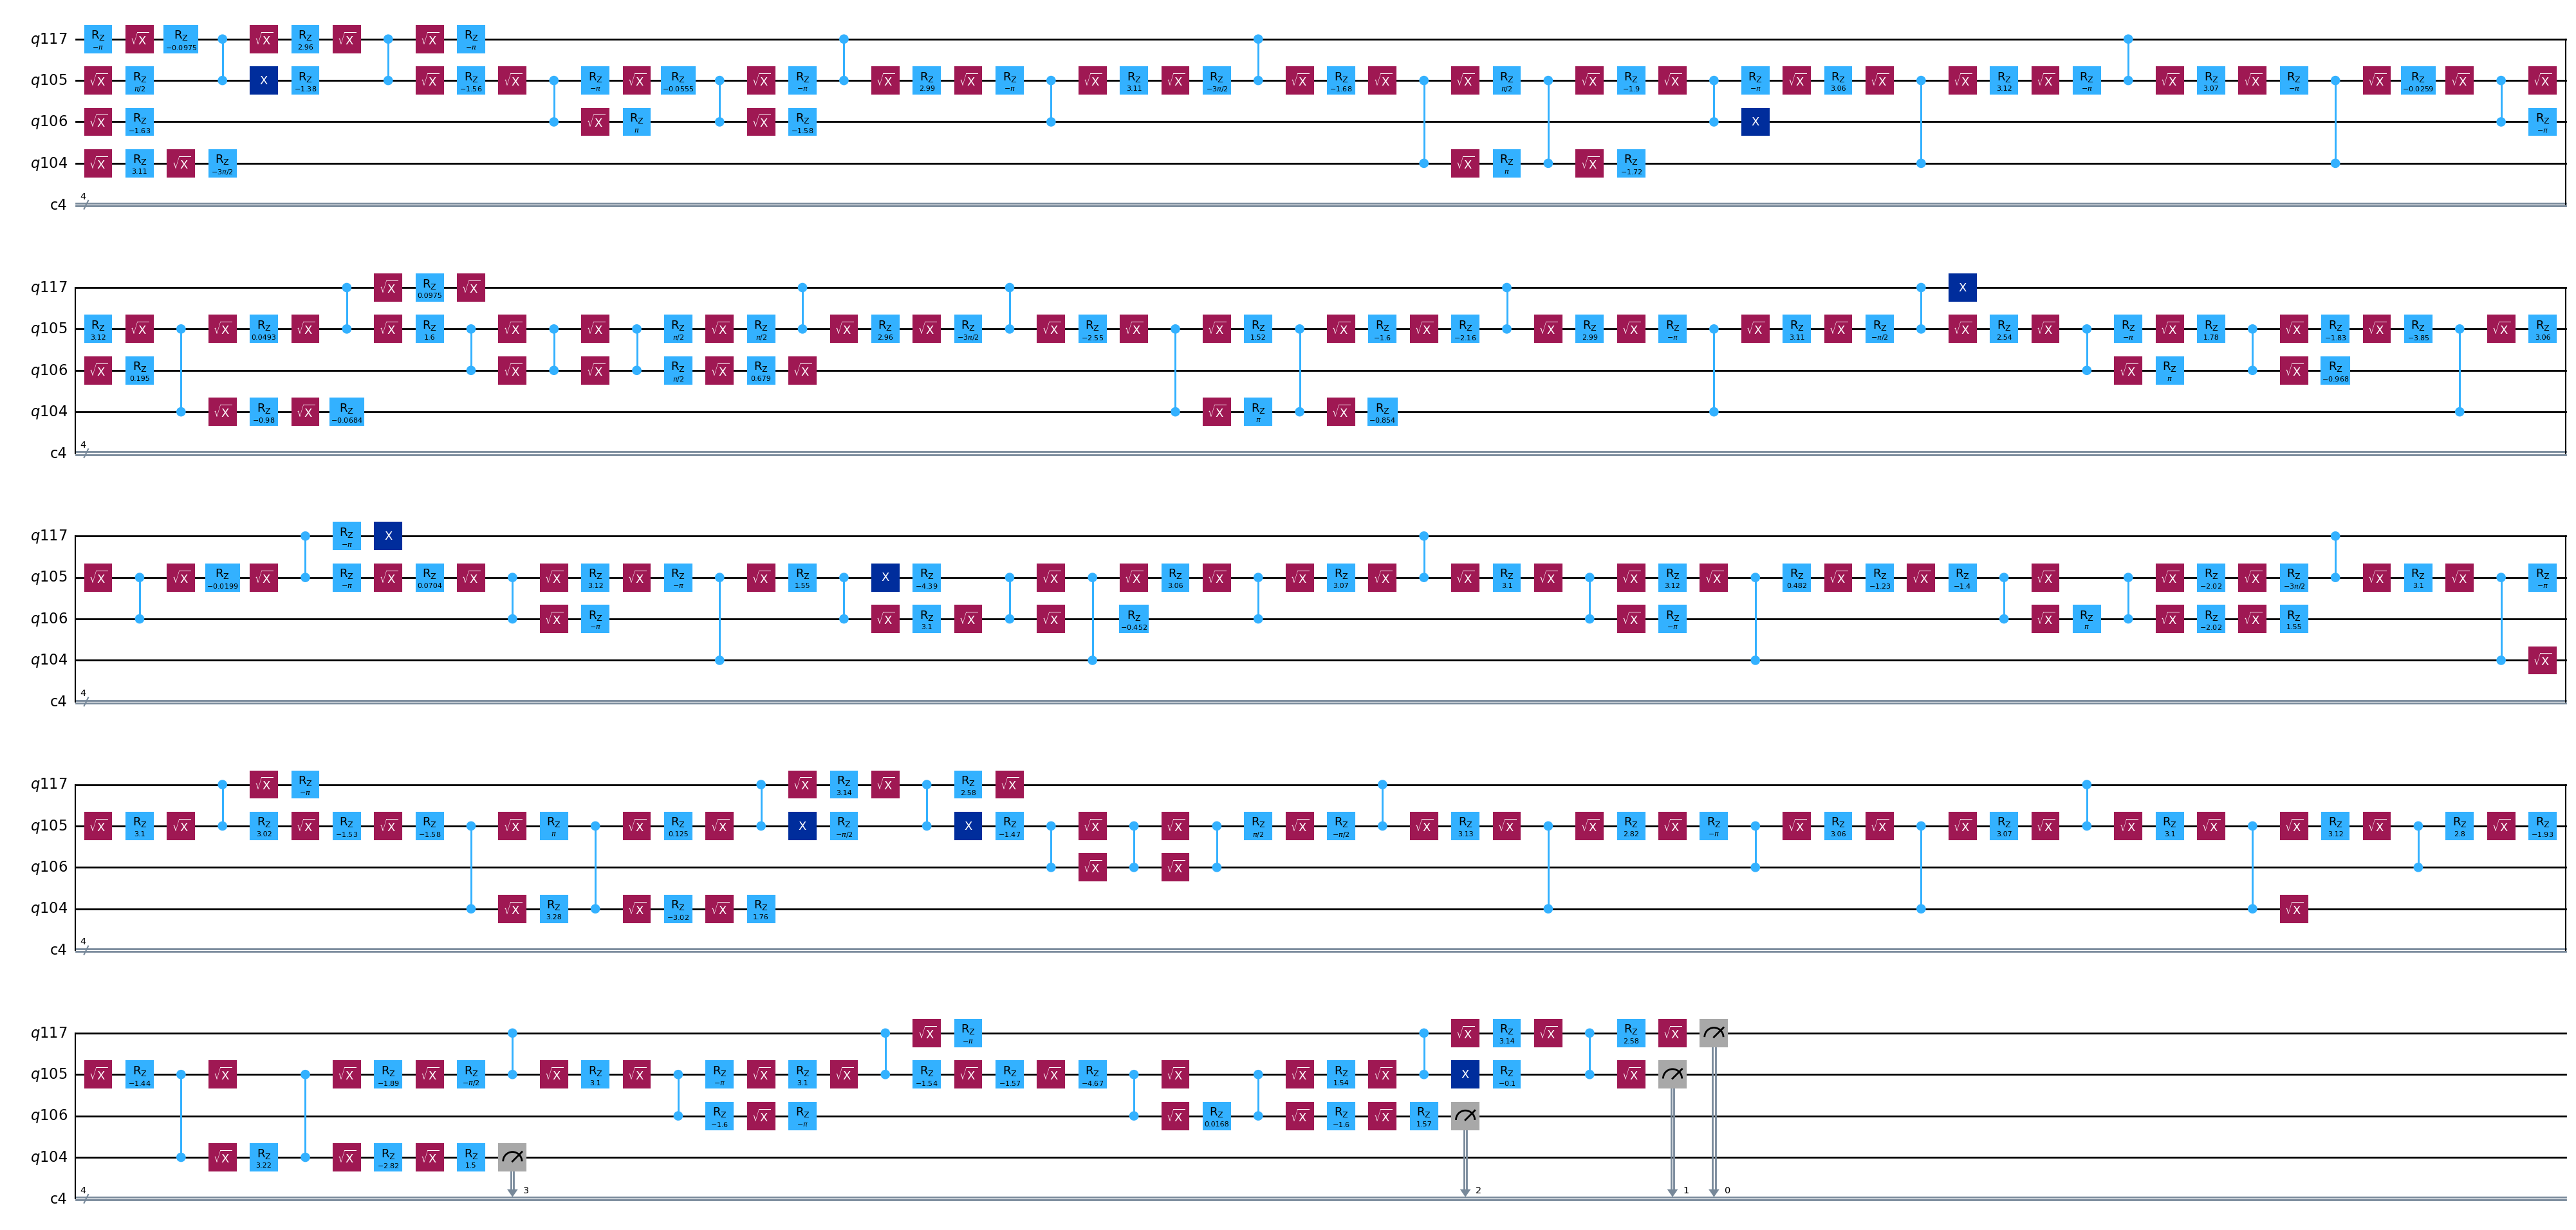

In [27]:
n = 'amp-ddd'
print(
    circuits_real[n][0].depth(),
    circuits_real[n][0].num_nonlocal_gates(),
)
circuits_real[n][0].trim().draw('mpl', fold=60)